# Image Classification with MNIST Using a Petastorm Dataset

In this notebook we will read a training dataset saved in the Petastorm format in the project's feature store and use that to train a Deep CNN defined in Keras/Tensorflow to classify images of digits in the MNIST dataset.

This notebook assumes that you have already created the training datasets in the feature store, which you can do by running this notebook: 

[Create Petastorm MNIST Dataset Notebook](PetastormMNIST_CreateDataset.ipynb)

![Petastorm 6](./../images/petastorm6.png "Petastorm 6")

## Imports

In [1]:
from hops import hdfs, featurestore, tensorboard, experiment

# IMPORTANT: must import tensorflow before petastorm.tf_utils due to a bug in petastorm
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.callbacks import TensorBoard
import json
import numpy as np
import pydoop
from petastorm import make_reader
from petastorm.tf_utils import tf_tensors, make_petastorm_dataset

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1559565096638_0006,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


## Constants

In this tutorial we will just use static hyperparameters, you can potentially achieve better accuracy by optimizing the hyperparameters using hyperparameter search ([docs](https://hopsworks.readthedocs.io/en/latest/hopsml/hopsML.html))

In [2]:
TRAIN_DATASET_NAME = "MNIST_train_petastorm"
TEST_DATASET_NAME = "MNIST_test_petastorm"
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 3*BATCH_SIZE
NUM_EPOCHS = 5
STEPS_PER_EPOCH = 80

## Step 1: Define The Model

In [3]:
def create_model():
    """
    Defines a three-layer CNN with batch normalization, dropout and max pooling, relu activation, 
    and softmax output
    """
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1))) 
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=2))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=2))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [4]:
create_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
__________

## Step 2: Define Tensorflow Dataset

Petastorm datasets can be read directly with tensorflow by using `make_reader` and `make_petastorm_dataset` from the Petastorm library

In [5]:
def create_tf_dataset(dataset_url, shuffle_buffer_size, batch_size, num_epochs):
    """
    Defines the Tensorflow Dataset Abstraction from the Petastorm Dataset.
    One-hot encodes the labels.
    """
    with make_reader(dataset_url, num_epochs=None, hdfs_driver='libhdfs',
                    workers_count=1, shuffle_row_groups=False) as train_reader:
        train_dataset = make_petastorm_dataset(train_reader)
        def preprocess(sample):
            return sample.image, tf.one_hot(sample.digit, 10)
        return train_dataset.map(preprocess).shuffle(shuffle_buffer_size).batch(batch_size).repeat(num_epochs)

## Step 3: Put it All Together in a Training Function


In [15]:
def train_fn():
    # get dataset path from the featurestore
    train_dataset_path = featurestore.get_training_dataset_path(TRAIN_DATASET_NAME)
    # get dataset
    dataset = create_tf_dataset(train_dataset_path, SHUFFLE_BUFFER_SIZE, BATCH_SIZE, NUM_EPOCHS)
    # define model
    model = create_model()
    # define optimizer
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
    # setup tensorboard
    tb_callback = TensorBoard(log_dir=tensorboard.logdir(), histogram_freq=0,write_graph=True, write_images=True)
    # setup model checkpointing
    model_ckpt_callback = keras.callbacks.ModelCheckpoint(tensorboard.logdir() + '/checkpoint-{epoch}.h5',monitor='acc', verbose=0, save_best_only=True)
    callbacks = [tb_callback, model_ckpt_callback]
    # train model
    history = model.fit(dataset, epochs=NUM_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, callbacks=callbacks)
    # save training history to HDFS
    results_path = hdfs.project_path() + "mnist/mnist_train_results.txt"
    hdfs.dump(json.dumps(history.history), results_path)
    # save trained model
    model.save("mnist_tf_ps.h5") #Keras can't save to HDFS in the current version so save to local fs first
    hdfs.copy_to_hdfs("mnist_tf_ps.h5", hdfs.project_path() + "mnist", overwrite=True) # copy from local fs to hdfs
    # return latest accuracy
    return history.history["acc"][-1]

## Step 4: Training Experiments 

We can use the experiments service to run our train_fn function and handle things like Tensorboard, logging, versioning etc. While the experiment is running you can monitor it using Tensorboard and the logs, it is explained in the README [here](https://github.com/logicalclocks/hops-util-py).

In [16]:
experiment.launch(train_fn, name="mnist_tf_ps", 
                  description="Petastorm MNIST Tensorflow Example", local_logdir=True)

Finished Experiment 

'hdfs://10.0.2.15:8020/Projects/demo_featurestore_admin000/Experiments/application_1559565096638_0006/launcher/run.2'

## Step 5: Plot Training Results

Inside the `train_fn` function we saved the training history to HDFS, which means we can later read it in %%local mode for plotting.

### Load Training Results From HDFS

In [17]:
%%local
import json
from hops import hdfs
import matplotlib.pyplot as plt
from pylab import rcParams
results_path = hdfs.project_path() + "mnist/mnist_train_results.txt"
results = json.loads(hdfs.load(results_path))

### Plot Loss/Epoch During Training

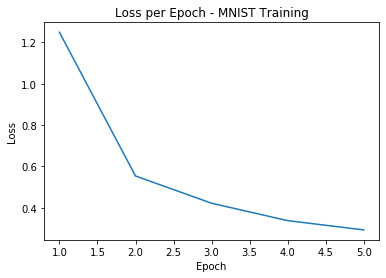

In [18]:
%%local
%matplotlib inline
y = results["loss"] #loss
x = list(range(1, len(y)+1))#epoch
plt.title("Loss per Epoch - MNIST Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,y)

### Plot Accuracy/Epoch During Training

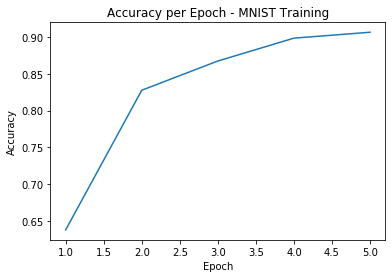

In [19]:
%%local
%matplotlib inline
y = results["acc"] #acc
x = list(range(1, len(y)+1))#epoch
plt.title("Accuracy per Epoch - MNIST Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(x,y)

## Step 6: Evaluation Using Trained Model and Test Dataset

Inside the `train_fn` function we saved the trained model to HDFS in the hdf5 format. We can load the weights of this model and use for serving predictions or for evaluation, in this example we will evaluate the model against the test set. 

### Load Model Weights

In [20]:
model_path_hdfs = hdfs.project_path() + "mnist/" + "mnist_tf_ps.h5"

In future releases of Tensorflow, Keras will be able to read directly from HDFS, but currently it is not supported. To get around this we can download the hdf5 model in the local file system and load it from there using `model.load_weights()`. 

In [23]:
local_path = hdfs.copy_to_local(model_path_hdfs, overwrite=True)

Started copying hdfs://10.0.2.15:8020/Projects/demo_featurestore_admin000/mnist/mnist_tf_ps.h5 to local disk on path /srv/hops/hopsdata/tmp/nm-local-dir/usercache/FatxKv_Lnvnybr5ulVBa6ZBxZaETIhWRCL9ga70hOV8/appcache/application_1559565096638_0006/container_e01_1559565096638_0006_01_000001/

Finished copying

In [24]:
local_path

'/srv/hops/hopsdata/tmp/nm-local-dir/usercache/FatxKv_Lnvnybr5ulVBa6ZBxZaETIhWRCL9ga70hOV8/appcache/application_1559565096638_0006/container_e01_1559565096638_0006_01_000001//mnist_tf_ps.h5'

In [25]:
loaded_model = create_model()
loaded_model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
loaded_model.load_weights(local_path)

### Evaluate Loaded Model

In [24]:
# We have 10 000 Test examples, we can evaluate in batches of 100 to speed up the process
BATCH_SIZE = 100
NUM_EPOCHS = 100 
# get dataset path from the featurestore
test_dataset_path = featurestore.get_training_dataset_path(TEST_DATASET_NAME)
test_dataset = create_tf_dataset(test_dataset_path, SHUFFLE_BUFFER_SIZE, BATCH_SIZE, NUM_EPOCHS)

In [25]:
score = loaded_model.evaluate(test_dataset, verbose=1, steps=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1/1 [==============================] - 1s 768ms/step
Test loss: 0.0319652184844017
Test accuracy: 0.9900000095367432